In [120]:
import os
import numpy
import subprocess
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot
import tqdm
import time

In [121]:
# remote mount the GRAMS directory on local machine (requires SSHFS)
host = "ub"
remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "
GRAMSdir = os.path.expanduser("~/remote_mount")
os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

# mount and unmount commands
mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
unmount = f"umount {GRAMSdir}"

try:
    # make sure the directory is not currently mounted, then mount
    subprocess.run(unmount, shell=True, check=True)
    subprocess.run(mount, shell=True, check=True)
except:
    # otherwise just directly mount
    subprocess.run(mount, shell=True, check=True)

umount(/Users/svan/remote_mount): Resource busy -- try 'diskutil unmount'
mount_macfuse: mount point /Users/svan/remote_mount is itself on a macFUSE volume


CalledProcessError: Command 'sshfs ub:/home/ub/WinDriver/wizard/GRAMS_project_am  /Users/svan/remote_mount -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa' returned non-zero exit status 1.

In [ ]:
# alternatively, you can set this directory manually:
## GRAMSDir = "/path/to/decoded/root/files"

## Waveform Plotter

In [122]:
# INPUTS/CONFIG

file_list = [1] # list of files you would like plotted
active_ch = 6 # channel number of interest
event_id = 13 # event number
fem_id = 11 # FEM number (usually slot 11 or 12)

overlay = 1 # set to 0 for individual plots, 1 for overlaid plots
aver

NameError: name 'aver' is not defined

In [123]:
if overlay == 1:
    plt.figure()

for filename in file_list:
    # open file and extract tree into a pandas dataframe
    file = uproot.open(f"{GRAMSdir}/outfile_{filename}.root")
    tree = file["adc_tree"]
    df = tree.arrays(library="pd")

    # slice dataframe for desired channel, FEM, and event
    slice_df = df[(df['fem_id'] == fem_id) & (df['event_id'] == event_id) & (df['channel_id'] == active_ch)]

    # create time axis (2 MHz sampling rate -> 0.5 us steps)
    time = 0.5*(slice_df.index - slice_df.index.min())
    
    # plot
    if overlay == 1:
        # if overlay is enabled, plot on the same figure
        plt.plot(time, slice_df['adc_count'], label=f'Run {filename}')
    else:
        # if overlay is disabled, new figure for each run
        plt.figure()
        plt.plot(time, slice_df['adc_count'])
        plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}, Run {filename}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.show()
    
# show legend if overlay is enabled
if overlay == 1:
    plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}')
    plt.xlabel('Time (us)')
    plt.ylabel('ADC Counts')
    plt.xlim(time.min(), time.max())
    plt.ylim(0, 4095)
    plt.grid(True)
    plt.legend()
    plt.show()

KeyInFileError: not found: 'adc_tree' (with any cycle number)

    Available keys: (none!)

in file /Users/svan/remote_mount/outfile_1.root

<Figure size 640x480 with 0 Axes>

In [ ]:
# average plotter

## Linearity/Dynamic Range

In [112]:
# INPUTS/CONFIG

active_ch = [6, 8, 12, 14, 16, 20, 22, 24] # channel numbers of interest
fem_id = 12 # FEM number (usually slot 11 or 12)
file_id = f"{GRAMSdir}/file_id.csv" # path to .csv with run IDs, run input pulse heights in mV, and ADC ch. no's

overlay = 1 # set to 0 for individual plots, 1 for overlaid plots

### ADC Amplitude vs. Input Charge Plotter

analyzing channel 24: 100%|█████████████████████| 13/13 [00:12<00:00,  1.03it/s]


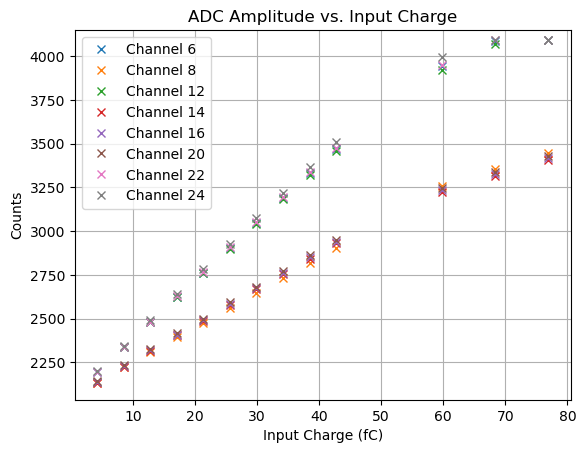

In [113]:
# read file_id into dataframe
csv = pd.read_csv(file_id)

#initialize figure
if overlay == 1:
    ampQ, ax = plt.subplots()

for ch in active_ch:
    # extract file_list for given channel
    slice_ch = csv[csv.iloc[:,2].isin([ch])]
    file_list = slice_ch.iloc[:,0].tolist()
    
    # extract pulse heights in mV for this file_list
    slice_mV = csv[csv.iloc[:, 0].isin(file_list)]
    mV = slice_mV.iloc[:, 1].tolist()
    
    # convert to charge
    Vdiv = (1/11) # preamp voltage divider
    Cin = 1 # preamp input capacitance, in pF
    Q = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
    
    peaks = []
    for filename in tqdm.tqdm(file_list, desc=f'analyzing channel {ch}', total=len(file_list)):
        # open file and extract tree into a pandas dataframe
        file = uproot.open(f"{GRAMSdir}/outfile_{filename}.root")
        tree = file["adc_tree"]
        df = tree.arrays(library="pd")
        
        # slice dataframe for desired FEM and channel, find max height for each event
        slice_df = df[(df['fem_id'] == fem_id) & (df['channel_id'] == ch)]
        grouped = slice_df.groupby('event_id')
        max_counts = grouped['adc_count'].max()
        average_max = peaks.append(max_counts.mean())
    
    # standard deviation
    std_dev = np.std(peaks)
    
    if overlay == 1:
        # if overlay is enabled, plot on the same figure
        ax.plot(Q, peaks, marker='x', linestyle='None', label=f'Channel {ch}')
    else:
        # if overlay is disabled, new figure for each run
        plt.figure()
        plt.plot(Q, peaks, marker='x', linestyle='None')
        plt.title(f'ADC Amplitude vs. Input Charge, Channel {ch}')
        plt.xlabel('Input Charge (fC)')
        plt.ylabel('Counts')
        plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.show()
        
# show legend if overlay is enabled
if overlay == 1:
    ax.set_title('ADC Amplitude vs. Input Charge')
    ax.set_xlabel('Input Charge (fC)')
    ax.set_ylabel('Counts')
    ax.set_ylim(ax.get_ylim()[0], 4150)
    ax.legend()
    ax.grid(True)
    ampQ

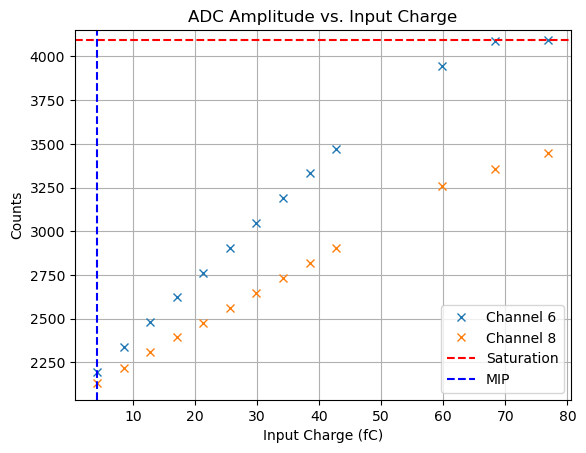

In [105]:
# add noise, saturation, and MIP bound to plot (only if they don't already exist)
if not any(line.get_label() == 'Saturation' for line in ax.get_lines()):
    ax.axhline(y=4095, color='r', linestyle='--', label='Saturation')
if not any(line.get_label() == 'MIP' for line in ax.get_lines()):
    ax.axvline(x=4.27, color='b', linestyle='--', label='MIP')
# if not any(line.get_label() == 'Noise' for line in ax.get_lines()):
#     ax.axhline(y=4095, color='r', linestyle='--', label='Noise')

ax.legend()
ampQ

### Linearity